In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import gcmpyo3

from core.amp.likelihood import probit_likelihood
from core.amp.prior.nonseparable_gaussian_prior import NonSepGaussianPrior
import core.erm.logistic_regression as logistic_regression
from core.utility import KERNEL_COEFICIENTS, get_additional_noise_from_kappas, LOGISTIC_APPROX_COEF, sigmoid, build_gcm_from_activation

%load_ext autoreload
%autoreload 2

In [13]:
d         = 200
seeds     = 30

n_over_d  = 2.0 
noise_std = 0.5
noise_var = noise_std**2

activation= 'erf'
_, kappa1, kappastar = KERNEL_COEFICIENTS[activation]

In [14]:
# inv_alpha_range = np.linspace(0.5, 4.5, n_alpha)

inv_alpha_range = np.array([0.1, 0.14949494949494951, 0.198989898989899, 0.24848484848484848, 0.297979797979798, 0.3474747474747475, 0.396969696969697, 0.44646464646464656, 0.495959595959596, 0.5454545454545455, 0.5949494949494949, 0.6444444444444445, 0.693939393939394, 0.7434343434343434, 0.7929292929292932, 0.8424242424242424, 0.891919191919192, 0.9414141414141416, 0.990909090909091, 1.0404040404040404, 1.0898989898989901, 1.1393939393939396, 1.188888888888889, 1.2383838383838386, 1.287878787878788, 1.3373737373737375, 1.386868686868687, 1.4363636363636367, 1.4858585858585862, 1.5353535353535357, 1.5848484848484852, 1.6343434343434347, 1.6838383838383841, 1.7333333333333334, 1.782828282828283, 1.8323232323232326, 1.881818181818182, 1.9313131313131315, 1.9808080808080812, 2.0303030303030307, 2.0797979797979806, 2.1292929292929297, 2.178787878787879, 2.2282828282828286, 2.277777777777778, 2.327272727272728, 2.376767676767677, 2.4262626262626266, 2.4757575757575765, 2.525252525252526, 2.5747474747474755, 2.624242424242425, 2.6737373737373744, 2.7232323232323234, 2.772727272727274, 2.8222222222222233, 2.8717171717171723, 2.921212121212122, 2.9707070707070717, 3.020202020202021, 3.06969696969697, 3.11919191919192, 3.168686868686869, 3.2181818181818187, 3.267676767676768, 3.3171717171717177, 3.366666666666668, 3.416161616161617, 3.465656565656567, 3.5151515151515156, 3.564646464646465, 3.6141414141414154, 3.663636363636365, 3.713131313131313, 3.7626262626262625, 3.812121212121213, 3.8616161616161624, 3.911111111111112, 3.9606060606060622, 4.010101010101011, 4.05959595959596, 4.10909090909091, 4.158585858585859, 4.208080808080809, 4.257575757575759, 4.307070707070707, 4.356565656565657, 4.406060606060607, 4.455555555555557, 4.505050505050505, 4.5545454545454565, 4.604040404040404, 4.653535353535354, 4.703030303030304, 4.752525252525253, 4.802020202020202, 4.851515151515152, 4.901010101010103, 4.950505050505051, 5.0])
erm_lambda_error= np.array([0.4948641675624909, 0.315027860125702, 0.2289015735067704, 0.1805432424510157, 0.1511629489389163, 0.1326314065265229, 0.1208215621651776, 0.1133949452542589, 0.1089241884437892, 0.1064945387494054, 0.1055010928571638, 0.1055346979437521, 0.1063132774359931, 0.1076388500281629, 0.1093699472123605, 0.1114038507315236, 0.1136647984464952, 0.1160959635321169, 0.118654282189106, 0.1213066280976728, 0.1240273105786524, 0.1267961893388604, 0.1295972453034324, 0.1324178255026463, 0.1352477667398085, 0.1380789019091741, 0.1409045940435625, 0.1437194967580672, 0.1465193607823614, 0.149300562921981, 0.1520603756877827, 0.1547964121013285, 0.1575069246215206, 0.1601904049243686, 0.1628457314929028, 0.1654720248811053, 0.1680686278057473, 0.1706350404455899, 0.1731709258473108, 0.1756760242332592, 0.1781503663353607, 0.1805938818233405, 0.1830066946143113, 0.1853887717636199, 0.1877405119052438, 0.1900620278835475, 0.1923536635631799, 0.194615624824946, 0.1968482847414502, 0.1990520836168824, 0.2012271349352726, 0.2033741468407735, 0.2054933462213715, 0.2075850248057167, 0.20964977831588, 0.211687926686165, 0.213699605410008, 0.2156856816783905, 0.2176463879201292, 0.2195820895647036, 0.2214931632914623, 0.2233800902797777, 0.2252432612427233, 0.2270830157057617, 0.2288998080058146, 0.2306938549630565, 0.2324657352756926, 0.2342157849010164, 0.2359443539310805, 0.2376517069339253, 0.239338415692798, 0.2410047571186897, 0.2426508164134945, 0.2442770248147783, 0.2458841138172516, 0.2474719432648314, 0.2490412418680572, 0.2505918759998748, 0.2521243389772842, 0.253639141327817, 0.2551361817435343, 0.256616120259957, 0.2580787943336635, 0.2595251522417257, 0.2609550476659384, 0.262368974913822, 0.2637667850821683, 0.2651489002796256, 0.2665157191305245, 0.2678674362521885, 0.2692042778352821, 0.2705265632721294, 0.2718343262050686, 0.2731280457912266, 0.2744078568544544, 0.2756735586232913, 0.2769261353999659, 0.2781651962877835, 0.2793913613029409, 0.2806045655446176])

index = [ i for i in range(0, len(inv_alpha_range), 5) if 4.5 >= inv_alpha_range[i] >= 0.5 ]

inv_alpha_range = inv_alpha_range[index]
erm_lambda_error = erm_lambda_error[index]
n_alpha = len(inv_alpha_range)

In [15]:
max_p        = int(n_over_d * d * inv_alpha_range[-1])
F_global     = np.random.normal(0.0, 1.0, size=(max_p, d)) / np.sqrt(d)

In [16]:
def generate_logit_data(kappa1, kappastar, F, n, teacher_dim, student_dim, noise_std, wstar = None):
    if wstar is None:
        wstar = np.random.normal(0.0, 1.0, size=teacher_dim)
        wstar = wstar * np.sqrt(teacher_dim) / np.linalg.norm(wstar)

    X0 = np.random.normal(0.0, 1.0, size=(n, teacher_dim))
    V  = kappa1 * X0 @ F.T  + kappastar * np.random.normal(0.0, 1.0, size=(n, student_dim))
    Y = 2.0 * np.random.binomial(1.0, p = sigmoid(X0 @ wstar / np.sqrt(teacher_dim) + noise_std * np.random.normal(0.0, 1.0, size=n)) ) - 1.0
    return wstar, V / np.sqrt(student_dim), Y

In [26]:
def inv_hessian(w, X, Y, lambda_):
    p = len(w)
    D = np.diag([sigmoid(w @ x) * (1.0 - sigmoid(w @ x)) for x in X])
    hessian     = X.T @ D @ X + lambda_ * np.eye(p)
    return np.linalg.inv(hessian)

def inv_hessian_trace(w, X, Y, lambda_, Omega):
    p = len(w)
    return np.trace(inv_hessian(w, X, Y, lambda_) @ Omega / p)

In [27]:
def trial(d, n_over_d, inv_alpha_range, erm_lambda_error):
    hessian_list, m_list, q_list = [], [], []

    for inv_alpha, lambda_ in tqdm(zip(inv_alpha_range, erm_lambda_error)):
        alpha = 1.0 / inv_alpha
        gamma = n_over_d * inv_alpha
        # student_dim 
        p     = int(gamma * d)
        
        # build the matrices / covariance matrices
        F = F_global[:p]
        wstar, X, Y = generate_logit_data(kappa1, kappastar, F, n, d, p, noise_std)
        
        what     = logistic_regression.solve_logistic_regression(X, Y, lambda_)

        Omega = kappa1**2 * F @ F.T + kappastar**2 * np.eye(p)
        m_list.append(kappa1 * wstar @ F.T @ what / np.sqrt(p * d))
        q_list.append(what @ Omega @ what / p)
        hessian_list.append(inv_hessian_trace(what, X, Y, lambda_, Omega))
    return m_list, q_list, hessian_list

In [28]:
hessian_array, q_array, m_array = np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha))
for s in range(seeds):
    try:
        m_list, q_list, hessian_list = trial(d, n_over_d, inv_alpha_range, erm_lambda_error)
        q_array[s] = q_list
        m_array[s] = m_list
        hessian_array[s] = hessian_list
    except Exception as e:
        print(e)
        q_array[s] = q_array[s-1]
        m_array[s] = m_array[s-1]
        hessian_array[s] = hessian_array[s-1]

16it [04:43, 17.74s/it]


In [30]:
m_list = np.mean(m_array, axis=0)
q_list = np.mean(q_array, axis=0)
hessian_list = np.mean(hessian_array, axis=0)

In [29]:
qs_for_erm_error = []
ms_for_erm_error = []


for inv_alpha, lambda_ in tqdm(zip(inv_alpha_range, erm_lambda_error)):
    alpha = 1. / inv_alpha
    gamma = n_over_d / alpha
    
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, lambda_, 1.0, "logit", 1e-6, False)
    qs_for_erm_error.append(q)
    ms_for_erm_error.append(m)

16it [00:00, 18.04it/s]


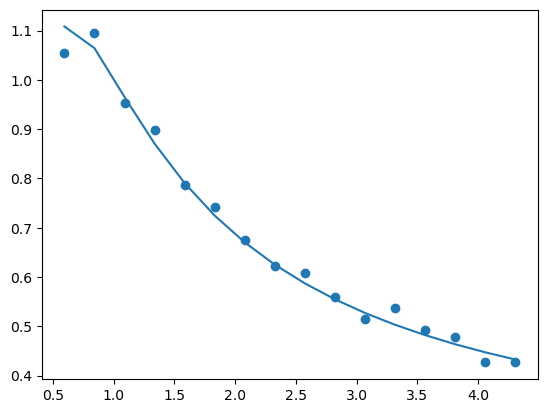

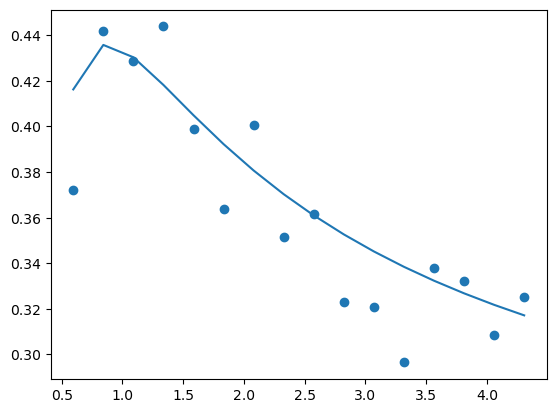

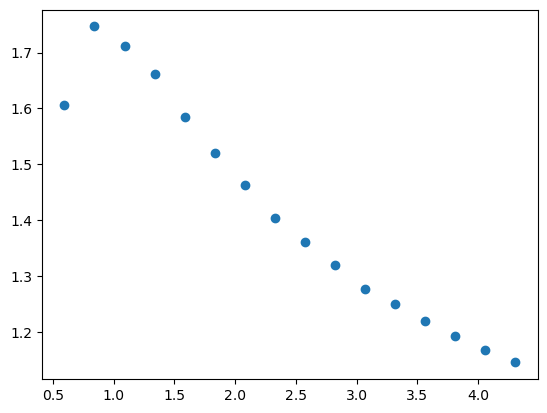

In [31]:
plt.scatter(inv_alpha_range, m_list)
plt.plot(inv_alpha_range, np.array(ms_for_erm_error))
plt.show()

plt.scatter(inv_alpha_range, q_list)
plt.plot(inv_alpha_range, np.array(qs_for_erm_error))
plt.show()

In [32]:
print('Experimental values of m : ')
print(list(m_list))
print('Experimental values of q : ')
print(list(q_list))
print('Experimental values of Hessian trace : ')
print(list(hessian_list))

[0.5949494949494949, 0.8424242424242424, 1.0898989898989901, 1.3373737373737375, 1.5848484848484852, 1.8323232323232326, 2.0797979797979806, 2.327272727272728, 2.5747474747474755, 2.8222222222222233, 3.06969696969697, 3.3171717171717177, 3.564646464646465, 3.812121212121213, 4.05959595959596, 4.307070707070707]
[0.3720913863775704, 0.44192257380128896, 0.4286346467631229, 0.4438587109248014, 0.3988640265635139, 0.3638438139390683, 0.40044880250622883, 0.3517310705623505, 0.36183096884894256, 0.3228809333838219, 0.32090058756520845, 0.2964955726026915, 0.33785321199989476, 0.3323564799458265, 0.3083576317343667, 0.32513194030240367]
[1.0540900528704582, 1.0943161625723314, 0.9529720726968399, 0.8984531437673715, 0.7875771542221147, 0.7417027699854007, 0.6742120745769533, 0.6223413604665454, 0.6079432133387663, 0.5587887549625355, 0.5153446387576096, 0.536854308305057, 0.49352930067254686, 0.4793509278111174, 0.42667530526561975, 0.42770751592999073]
[1.606405370820988, 1.746695138225795